# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
* Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fÃ©dÃ©rale-de-lausanne-epfl).Store the resulting dataset in a pandas DataFrame and answer the following questions:
  * Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

  * Answer the previous question aggregating the data by (c) country and (d) region.

  Plot your data using bar charts and describe briefly what you observed.

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import json 

import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette('Blues')

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")


import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [ ]:
'''
# get name, rank, country and region of the 200 first universities
url='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508005996450'
universities= requests.get(url).json()['data'][0:200]
df_top = pd.DataFrame(universities)
df_top = df_top.drop(['cc','core_id','guide', 'logo','score','stars','nid'], axis=1)

#list of urls to universities pages
urls =list(df_top['url'])

# function to get the rest of the needed information on each university page in a dictionnary
def get_details(url):
    university= requests.get('https://www.topuniversities.com' + url)
    soup= BeautifulSoup(university.text,'html.parser')
    data= soup.find_all('div', class_= 'faculty-main')
    df_top.head()

    # number of faculty members international
    if(soup.find_all('div', class_ = 'inter faculty') != []):
        inter_fac_mem = float(soup.find_all('div', class_ = 'inter faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_fac_mem = float('nan')
        
    # number of faculty members total
    if(soup.find_all('div', class_ = 'total faculty')!= []):
        total_fac_mem = float(soup.find_all('div', class_ = 'total faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_fac_mem = float('nan')
        
    # number of students international
    if(soup.find_all('div', class_ = 'total inter')!= []):
        inter_student = float(soup.find_all('div', class_ = 'total inter')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_student = float('nan')
        
    # number of students total
    if(soup.find_all('div', class_ = 'total student')!= []):
        total_student = float(soup.find_all('div', class_ = 'total student')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_student = float('nan')

    details = {'url' : url, '#faculty members international (QS)' : inter_fac_mem,
          '#faculty members total (QS)' : total_fac_mem,
          '#students international (QS)': inter_student,
          '#students total (QS)' : total_student}
    return details

#list of dictionnaries 
details = []    
for url in urls:
    details.append(get_details(url))
#convert to pd.DataFrame
df_top2 = pd.DataFrame(details)

#merge the two dataframes with the url
df_top= pd.merge(df_top, df_top2, 'outer')
df_top.rename(columns={'rank_display': 'QS rank', 'title': 'name'}, inplace=True)
df_top = df_top.drop('url', axis=1)
'''

In [ ]:
#USE PICKLE TO SAVE DF
'''
filename="./data/QS_ranking"
df_qs.to_pickle(filename)
'''


In [2]:
#USE PICKLE TO LOAD DF
filename="./data/QS_ranking"
df_top =pd.read_pickle(filename)
df_top.head()


,country,QS rank,region,name,#faculty members international (QS),#faculty members total (QS),#students international (QS),#students total (QS)
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0


In [3]:
df_top['QS rank']=df_top['QS rank'].str.extract('(\d+)').astype('int64')
bool_dup = df_top['QS rank'].duplicated()
ind_dup = bool_dup[bool_dup == True].index

#until no more duplicates
for ind in ind_dup :
    #add +1 the all the ranks below this duplicate
    df_top['QS rank'][ind : len(df_top['QS rank'])] = df_top['QS rank'][ind : len(df_top['QS rank']) ] + 1;
    
print(df_top['QS rank'].is_unique)



/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


True


In [4]:
df_top['ratio between faculty members and students'] = df_top['#faculty members total (QS)']/df_top['#students total (QS)']
df_top['ratio of international students'] = df_top['#students international (QS)']/df_top['#students total (QS)']

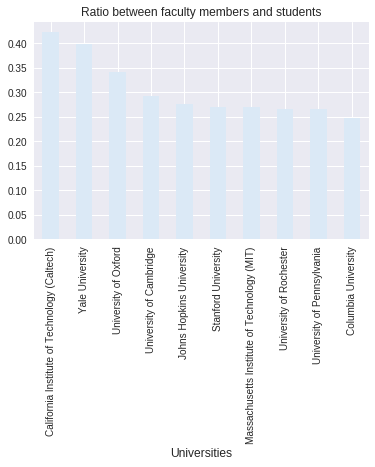

In [5]:
df_ratio1 = df_top.sort_values('ratio between faculty members and students', ascending =False)
df_ratio1.set_index(['name'],inplace=True)
df_ratio1= df_ratio1['ratio between faculty members and students']

ax = df_ratio1[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()


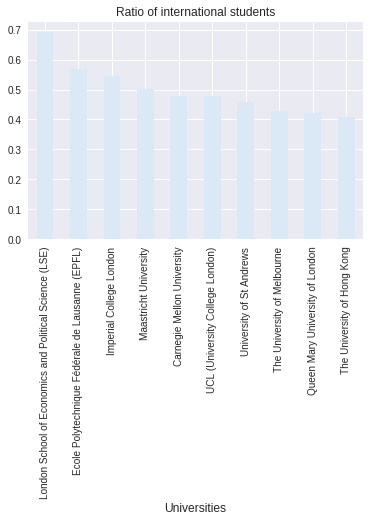

In [6]:
df_ratio2 = df_top.sort_values('ratio of international students', ascending =False)
df_ratio2.set_index(['name'],inplace=True)
df_ratio2= df_ratio2['ratio of international students']

ax = df_ratio2[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio of international students")
plt.show()

In [7]:
df_country = df_top.groupby('country').mean()
df_region = df_top.groupby('region').mean()

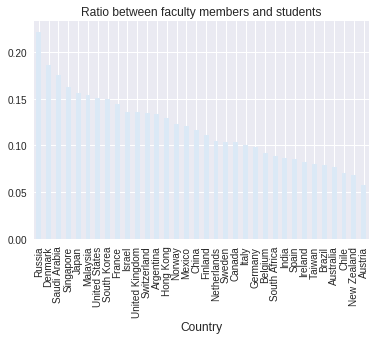

In [8]:
df_country_ratio1 = df_country.sort_values('ratio between faculty members and students', ascending =False)
df_country_ratio1= df_country_ratio1['ratio between faculty members and students']

ax = df_country_ratio1.plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

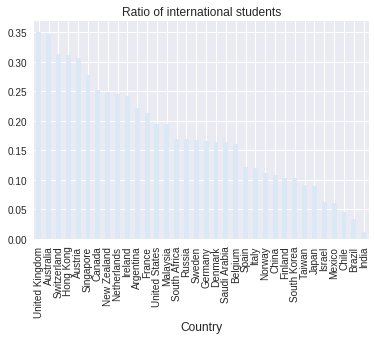

In [9]:
df_country_ratio2 = df_country.sort_values('ratio of international students', ascending =False)
df_country_ratio2= df_country_ratio2['ratio of international students']

ax = df_country_ratio2.plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio of international students")
plt.show()

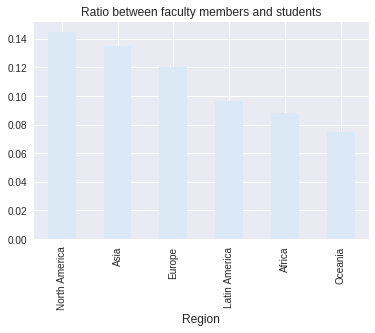

In [10]:
df_region_ratio1 = df_region.sort_values('ratio between faculty members and students', ascending =False)
df_region_ratio1= df_region_ratio1['ratio between faculty members and students']

ax = df_region_ratio1.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

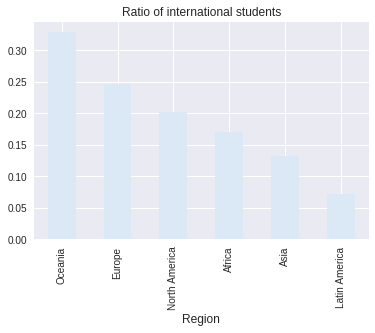

In [11]:
df_region_ratio2 = df_region.sort_values('ratio of international students', ascending =False)
df_region_ratio2= df_region_ratio2['ratio of international students']

ax = df_region_ratio2.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio of international students")
plt.show()

* Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

* Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

* Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

* Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [5]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [6]:

url='https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

json_dict= requests.get(url).json()
raw_data = pd.DataFrame(json_dict['data'])
raw_data.columns
df_time=raw_data[['name','rank','location','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]

df_time['rank']=df_time['rank'].str.extract('(\d+)').astype('int64')
df_time = df_time.loc[df_time['rank']<201]
df_time.rename(columns={'location':'country','stats_number_students':'students','stats_pc_intl_students':'international students','stats_student_staff_ratio':'staff'},inplace=True)

df_time['students'] = df_time['students'].str.replace(',','').astype('int64')

df_time['international students'] = df_time['international students'].str.extract('(\d+)').astype('float64')
df_time['international students'] = (df_time['international students']/100)*df_time['students'].astype('float64')
df_time['international students'] = df_time['international students'].astype('int64')

df_time['staff'] = df_time['staff'].astype('float64')
df_time['staff'] = df_time['students'].astype('float64')/df_time['staff']
df_time['staff'] = df_time['staff'].astype('int64')

df_time

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


,name,rank,country,students,international students,staff
0,University of Oxford,1,United Kingdom,20409,7755,1822
1,University of Cambridge,2,United Kingdom,18389,6436,1687
2,California Institute of Technology,3,United States,2209,596,339
3,Stanford University,3,United States,15845,3485,2112
4,Massachusetts Institute of Technology,5,United States,11177,3800,1284
5,Harvard University,6,United States,20326,5284,2283
6,Princeton University,7,United States,7955,1909,958
7,Imperial College London,8,United Kingdom,15857,8721,1390
8,University of Chicago,9,United States,13525,3381,2181
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,19233,7308,1317


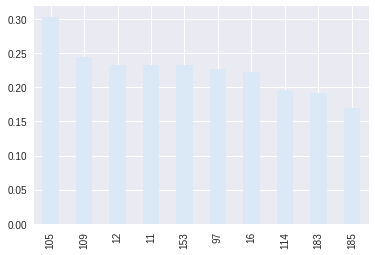

In [12]:
df_time['staff ratio']=df_time['staff'].astype('float64')/df_time['students']
barplot = df_time.sort_values('staff ratio',ascending=False)['staff ratio'].head(10).plot(kind='bar')

In [13]:
df_time['international students ratio']=df_time['international students'].astype('float64')/df_time['students']
df_time.sort_values('international students ratio',ascending=False).head()

,name,rank,country,students,international students,staff,staff ratio,international students ratio
24,london school of economics and political science,25,United Kingdom,10065,7146,825,0.081967,0.709985
178,university of luxembourg,179,Luxembourg,4969,2832,340,0.068424,0.569934
7,imperial college london,8,United Kingdom,15857,8721,1390,0.087658,0.549978
37,école polytechnique fédérale de lausanne,38,Switzerland,9928,5460,886,0.089243,0.549960
102,maastricht university,103,Netherlands,16727,8363,929,0.055539,0.499970


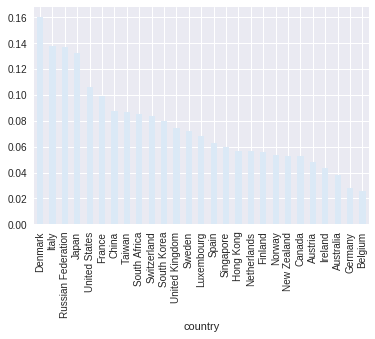

In [22]:
df_time.groupby(['country'])['staff ratio'].mean().sort_values(ascending=False).plot(kind='bar')

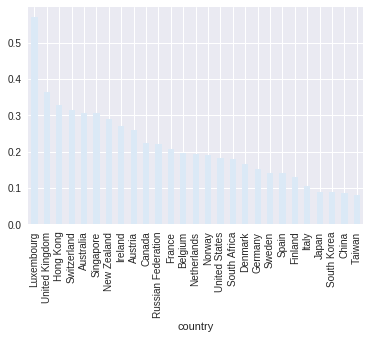

In [23]:
df_time.groupby(['country'])['international students ratio'].mean().sort_values(ascending=False).plot(kind='bar')

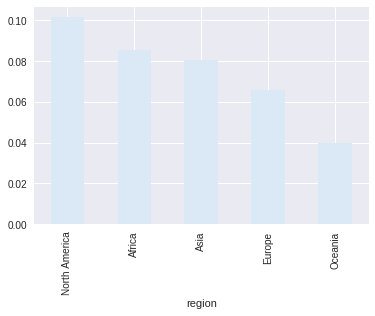

In [14]:
region = {'Asia':['China','Hong Kong','Japan','Singapore','South Korea','Taiwan']
          ,'Europe':['Austria','Belgium','Denmark','Finland','France','Germany','Ireland','Italy','Luxembourg','Netherlands','Norway','Russian Federation','Spain','Sweden','Switzerland','United Kingdom']
          ,'North America':['Canada','United States']
          ,'Africa':['South Africa']
          ,'Oceania':['Australia','New Zealand']}

region = { f : i for i in region for f in region[i] }

df_time['region'] = df_time['country'].map(region)

df_time.groupby(['region'])['staff ratio'].mean().sort_values(ascending=False).plot(kind='bar')

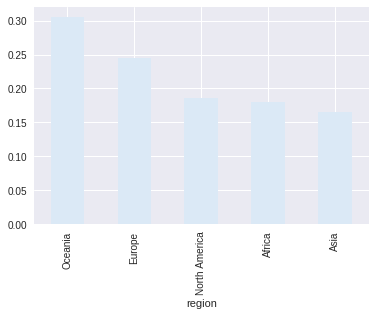

In [25]:
df_time.groupby(['region'])['international students ratio'].mean().sort_values(ascending=False).plot(kind='bar')

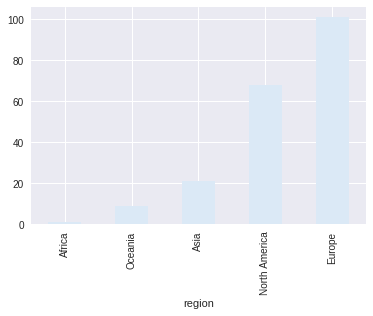

In [26]:
df_time.groupby(['region'])['rank'].count().sort_values(ascending=True).plot(kind='bar')

Merging both datasets

In [15]:
from difflib import SequenceMatcher

In [16]:
# set all to lower case
df_top['name'] = df_top['name'].str.lower()
df_time['name'] = df_time['name'].str.lower()

# merge 'in' universities with same string name
df_merged_in = pd.merge(df_top, df_time, how='inner')
df_merged_out = pd.merge(df_top, df_time, how='outer')

print(df_top.shape)
print(df_time.shape)
print(df_merged_in.shape)
print(df_merged_out.shape)

#find unies that are not directly matched

#df_top_rest = df_top['name'] df_merged_in['name'];
#df_time_rest = df_time['name']  - df_merged_in['name'];


(200, 10)
(200, 9)
(104, 16)
(296, 16)


In [17]:
mit_1 = df_top['name'].values[0]
mit_2 = df_time['name'].values[4]
oxford_2 = df_time['name'].values[0]
print('Similarity between ', mit_1, 'and ', mit_2, 'is : ', SequenceMatcher(None, mit_1, mit_2).ratio())
print('Similarity between ', mit_1, 'and ', oxford_2, 'is : ', SequenceMatcher(None, mit_1, oxford_2).ratio())

Similarity between  massachusetts institute of technology (mit) and  massachusetts institute of technology is :  0.925
Similarity between  massachusetts institute of technology (mit) and  university of oxford is :  0.2857142857142857


In [18]:


#find similarities of universities names per country

#country vector
countries = df_merged_out['country'].unique()
#for each country
for country in countries:
    #find uni in that country in both rankings
    df_top_uni = df_top['name'][df_top['country']== country];
    df_time_uni = df_time['name'][df_time['country']== country];
    
    
    
    
    
    


## Correlation matrix

In [19]:
import seaborn as sns
#TO CHANGE LATER
# merge 'in' universities with same string name

df_merged_in = pd.merge(df_top, df_time, how='inner')

print(df_merged_in.columns)
df_merged_in[[ 'QS rank', '#faculty members total (QS)',
        '#students total (QS)',
       '#students international (QS)',
       'ratio between faculty members and students',
       'ratio of international students','#faculty members international (QS)',  
              'rank','staff', 'students',
       'international students',  'staff ratio',
       'international students ratio']]


corr_pearson= df_merged_in.corr('pearson')

sns.heatmap(corr_pearson, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Index(['country', 'QS rank', 'region', 'name',
       '#faculty members international (QS)', '#faculty members total (QS)',
       '#students international (QS)', '#students total (QS)',
       'ratio between faculty members and students',
       'ratio of international students', 'rank', 'students',
       'international students', 'staff', 'staff ratio',
       'international students ratio'],
      dtype='object')


NameError: name 'corr' is not defined

 correlation  between
 
* faculty member international, faculty members total
* faculty member international, student international
* faculty member international, ratio fac/student
* faculty member international, international students (time)
* student international, ratio international students

In [ ]:
corr_spearman= df_merged_in.corr(method='spearman')

sns.heatmap(corr_spearman, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
corr_kendall= df_merged_in.corr('kendall')

sns.heatmap(corr_kendall, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Defining the best university

To determine the best university, we decided to use a Condorcet method. We group the univeristies two by two and we perform a vote (each university has a vote from one of the ranking if its score is higher than the other one). The overall score of the university is the number of vote it wins.

It has a drawback since it many of the univerities are tied in ranking. So we tried another to counter this effect by also considering the Shanghai ranking.

In [49]:
#Parsing the dataset of the Shanghai ranking

# get name, rank, country and region of the 200 first universities
"""
import re


# function to get the rest of the needed information on each university page in a dictionnary

universities= requests.get('http://www.shanghairanking.com/ARWU2017.html')
soup= BeautifulSoup(universities.text,'html.parser')
html_shanghai= soup.find_all('table', id="UniversityRanking")
rank_shanghai_even= html_shanghai[0].find_all('tr', class_="bgfd")
rank_shanghai_odd= html_shanghai[0].find_all('tr', class_="bgf5")

uni_list=[]
for uni in rank_shanghai_even[0:50]:
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})

    
for uni in rank_shanghai_odd[0:50]:
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})

df_shanghai=pd.DataFrame(uni_list)

df_shanghai=df_shanghai.sort_values('rank Shanghai', ascending=True)
df_shanghai.head()

df_shanghai.index.is_unique
df_shanghai.set_index('rank Shanghai')

#USE PICKLE TO SAVE DF
filename="./data/Shanghai_ranking"
df_shanghai.to_pickle(filename)
"""

'\nimport re\n\n\n# function to get the rest of the needed information on each university page in a dictionnary\n\nuniversities= requests.get(\'http://www.shanghairanking.com/ARWU2017.html\')\nsoup= BeautifulSoup(universities.text,\'html.parser\')\nhtml_shanghai= soup.find_all(\'table\', id="UniversityRanking")\nrank_shanghai_even= html_shanghai[0].find_all(\'tr\', class_="bgfd")\nrank_shanghai_odd= html_shanghai[0].find_all(\'tr\', class_="bgf5")\n\nuni_list=[]\nfor uni in rank_shanghai_even[0:50]:\n    uni_rank=int(uni.find(\'td\').text);\n    uni_name=uni.find(\'a\').text\n    uni_url=\'http://www.shanghairanking.com/\' + uni.find(\'a\')[\'href\']; \n    uni_request= requests.get(uni_url)\n    uni_soup= BeautifulSoup(uni_request.text,\'html.parser\')\n    uni_country= uni_soup.find(\'div\', class_="tab_content").find_all(\'td\')[5].text\n    uni_region= uni_soup.find(\'div\', class_="tab_content").find_all(\'td\')[3].text\n    uni_list.append({\'name\' : uni_name, \'rank Shanghai\' 

In [32]:
#loading the dataset

#USE PICKLE TO LOAD DF
filename="./data/Shanghai_ranking"
df_shanghai =pd.read_pickle(filename)
df_shanghai.head()

,country,name,rank Shanghai,region
0,USA,Harvard University,1,Northern America
50,USA,Stanford University,2,Northern America
1,UK,University of Cambridge,3,Northern Europe
51,USA,Massachusetts Institute of Technology (MIT),4,Northern America
2,USA,"University of California, Berkeley",5,Northern America


In [35]:
df_shanghai['name']=df_shanghai['name'].str.lower()
df_shanghai=df_shanghai[['name','rank Shanghai']]
df_rank = pd.merge(df_merged_out, df_shanghai, how='outer')
df_rank=df_rank[['name','rank','QS rank','rank Shanghai']]
df_rank.columns=['name','TI rank','QS rank','SH rank']

In [40]:
import numpy as np

def compute_vote(rank_serie):
    rank_array = np.array(rank_serie)
    rank_array[np.isnan(rank_array)]=201
    rank_mat=np.tile(rank_array,(len(rank_array),1))
    rank_cmp=np.less_equal(rank_mat,np.transpose(rank_mat)).astype(int)
    return rank_cmp

In [47]:
TI_cmp=compute_vote(df_rank['TI rank'])
SH_cmp=compute_vote(df_rank['SH rank'])
QS_cmp=compute_vote(df_rank['QS rank'])

In [46]:
tot_mat=np.greater(QS_cmp+TI_cmp,1).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
1,stanford university,3.0,2.0,2.0,318
4,university of cambridge,2.0,5.0,3.0,316
5,university of oxford,1.0,6.0,7.0,316
2,harvard university,6.0,3.0,1.0,315
7,imperial college london,8.0,8.0,27.0,311
8,university of chicago,9.0,9.0,10.0,310
12,princeton university,7.0,13.0,6.0,307
15,yale university,12.0,16.0,11.0,302
18,university of pennsylvania,10.0,19.0,17.0,301
16,johns hopkins university,13.0,17.0,18.0,301


We can see here the results of the Condorcet method considering only the Times and QS rankings, we can see that we got a unique best university (

In [48]:
tot_mat=np.greater(QS_cmp+TI_cmp+SH_cmp,1.5).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
1,stanford university,3.0,2.0,2.0,321
2,harvard university,6.0,3.0,1.0,320
4,university of cambridge,2.0,5.0,3.0,319
0,massachusetts institute of technology (mit),NaN,1.0,4.0,318
5,university of oxford,1.0,6.0,7.0,317
12,princeton university,7.0,13.0,6.0,316
7,imperial college london,8.0,8.0,27.0,314
201,california institute of technology,3.0,NaN,9.0,314
8,university of chicago,9.0,9.0,10.0,313
15,yale university,12.0,16.0,11.0,312
